In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import time
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
%matplotlib inline
colours = list(mcolors.TABLEAU_COLORS)

In this assignment you are going to see the surprising power of PCA for working with images. 

There is a famous dataset that is commonly used in machine learning called MNIST. It consists of small images of handwritten forms of the digits 0 to 9 for classification. The nice things about MNIST are that the problem is clear, the images are small (so computational time isn't too big), there is lots of data, and the problem is somehow the right level of difficulty. But the images are very boring. So a few years ago somebody produced fashion MNIST -- still tiny images (28 by 28 pixels), but of clothes rather than digits. Maybe more interesting if you like that kind of thing; I don't care, but somehow the images are slightly easier to look at. 

I've put a csv file containing a small part of fashion MNIST (`fmnist_small.csv`) on Blackboard. There are 10 classes, which I can't remember -- some internet searching will soon tell you -- and I've given you 300 of each class.

Each datapoint consists of a unique ID, a class (number 0-9), and then 784 ($=28 \times 28$) greyscale pixel values. 

**Task 1:** Load the data using `np.genfromtxt`, and plot 10 examples of each of the 10 classes in a little grid (as below). You will need to reshape the vector to make the image and then use `pl.imshow`. I used `pl.subplots` to make the grid. (3 marks)

A quick note: your computer might start to complain about the number of images you have open. If it does, reduce the number of examples in each plot to 5. 

In [2]:
loaded = np.genfromtxt("fmnist_small.csv")
print(np.shape(loaded))
print(loaded)

(3000, 786)
[[1691.    9.    0. ...    0.    0.    0.]
 [1671.    7.    0. ...    0.    0.    0.]
 [1833.    4.    0. ...   73.    5.    0.]
 ...
 [ 746.    9.    0. ...    0.    0.    0.]
 [2762.    3.    0. ...    0.    0.    0.]
 [ 726.    9.    0. ...    0.    0.    0.]]


In [3]:
ids = loaded[:,0].astype(int)
print(ids)
classes = loaded[:,1].astype(int)
print(classes)
images = loaded[:,2:].astype(int)
print(images)
classLabels = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")
# Class Labels were given by https://github.com/zalandoresearch/fashion-mnist

[1691 1671 1833 ...  746 2762  726]
[9 7 4 ... 9 3 9]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 73  5  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


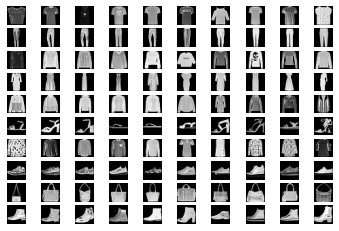

In [4]:
cols = 10
for i in range(10):
    thing = np.squeeze(np.where(classes == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(images[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')

You are going to use PCA on the vector of the data (so the 784 long vector, not the $28 \times 28$ image). You can use either my PCA or the one from sklearn. 

**Task 2:** Use one of the PCA implementations and make a scree plot of the total explained variance for the first 100 principal components. Use that to decide how many principal components to use. (3 marks)

In [5]:
# Here is PCA
def pca(data):
    # Compute the covariance matrix
    C = np.cov(data.T)

    # Get the eigenvalues and eigenvectors
    evals,evecs = np.linalg.eig(C)

    # Now need to sort them into descending order
    indices = np.argsort(evals)
    indices = indices[::-1]
    evecs = evecs[:,indices]
    evals = evals[indices]

    # Transform the data
    return np.dot(evecs.T,data.T).T, evals, evecs

In [6]:
x, evals, evecs = pca(images)

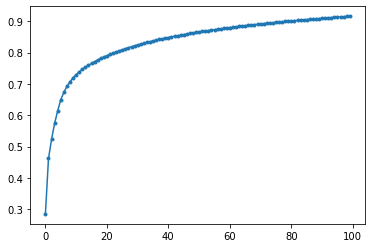

In [7]:
pl.plot(np.cumsum(evals)[:100]/np.sum(evals), '.-')

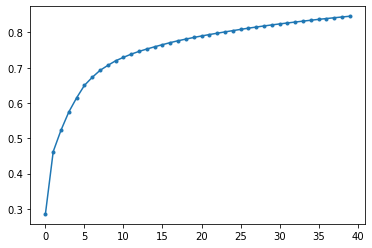

In [8]:
pl.plot(np.cumsum(evals)[:40]/np.sum(evals), '.-')
# I think 40 values is worth a try, as that gives about 85% of the variance
# Any less, and there will be too much unexplained variance
# Any more, and the additional computational time won't necessarily be worth the extra detail 

Before we do any more with that, let's see how crazy we can get. 

**Task 3:** Compute the first two principal components, and plot the points in 2D with a different colour for each class. I used `import matplotlib.colors as mcolors` together with the list of colours: `colours = list(mcolors.TABLEAU_COLORS)`. Comment on the results. (3 marks)

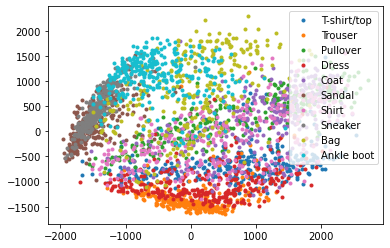

In [9]:
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    pl.plot(np.mean(x[:,0])-x[thing,0], x[thing,1]-np.mean(x[:,1]), '.', c = colours[i])
pl.legend(classLabels)

Each of the classes seem to be grouped together in clusters, but then these clusters often have overlap with other classes' clusters. Additionally, the overlapping clusters may be of items of clothing that are quite different.

For example, Coats (Class 4, grey dots) and Sandals (Class 5, brown dots) have a large amount of overlap, despite being two articles of clothing that are very different.

From this, we can conclude that the first two principal components are somewhat useful in categorising items of clothing, but  more information is required to make an accurate prediction of an article's category.

**Task 4:** Take the PCA transformed data in 2D, 20D, and 100D, and invert the PCA transformation. Plot the first 10 examples for each class for each of those datasets. (3 marks)

Then make a different set of plots by subtracting the original image from the inverted transformation. This will result in pixel values between -255 and 255. So add 255 to them and divide by 2 to get them back into the correct range. (2 marks) 

(784, 784) (784, 784) (784, 3000)


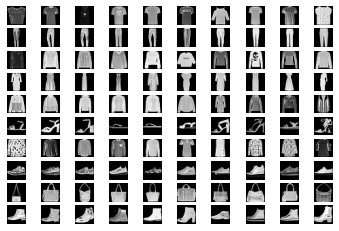

In [10]:
means = np.mean(images,axis=0)
print(np.shape(evecs), np.shape(evecs.T), np.shape(images.T))
reconstructed = np.transpose(np.dot(evecs,np.dot(evecs.T,images.T)))
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(reconstructed[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Reconstructed using all dimensions

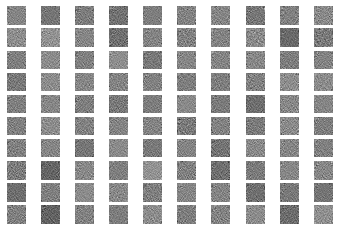

In [11]:
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        difference = (reconstructed[thing[j]]-images[thing[j]]+255)/2
        pl.imshow(difference.reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Difference from being reconstructed using all dimensions

(3000, 2) (2, 784)


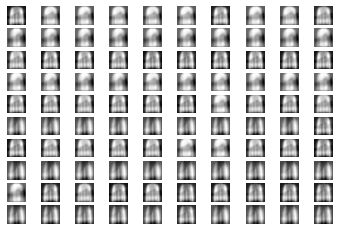

In [12]:
nDims = 2
print(np.shape(x[:,:nDims]), np.shape(evecs[:,:nDims].T))
reconstructed2 = np.dot(x[:,:nDims],evecs[:,:nDims].T)
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(reconstructed2[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Reconstructed using 2 dimensions

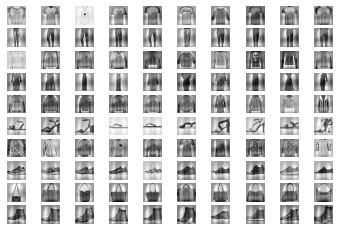

In [13]:
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        difference = (reconstructed2[thing[j]]-images[thing[j]]+255)/2
        pl.imshow(difference.reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Difference from being reconstructed using 2 dimensions

(3000, 20) (20, 784)


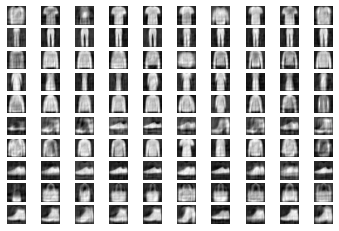

In [14]:
nDims = 20
print(np.shape(x[:,:nDims]), np.shape(evecs[:,:nDims].T))
reconstructed20 = np.dot(x[:,:nDims],evecs[:,:nDims].T)
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(reconstructed20[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Reconstructed using 20 dimensions

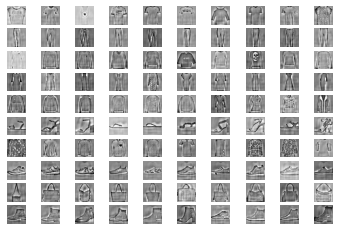

In [15]:
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        difference = (reconstructed20[thing[j]]-images[thing[j]]+255)/2
        pl.imshow(difference.reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Difference from being reconstructed using 20 dimensions

(3000, 100) (100, 784)


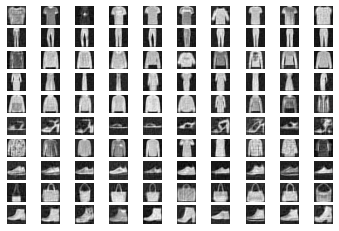

In [16]:
nDims = 100
print(np.shape(x[:,:nDims]), np.shape(evecs[:,:nDims].T))
reconstructed100 = np.dot(x[:,:nDims],evecs[:,:nDims].T)
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(reconstructed100[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Reconstructed using 100 dimensions

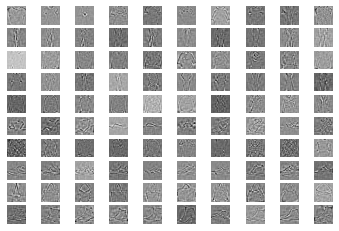

In [17]:
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        difference = (reconstructed100[thing[j]]-images[thing[j]]+255)/2
        pl.imshow(difference.reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Difference from being reconstructed using 100 dimensions

**Task 5:** Using however many principal components you think best, cluster the data using $k$-means with 10 centres. Plot the usual grid of 10 by 10 for 10 examples of each class. Comment on the results. (3 marks)

(3000, 40) (40, 784)


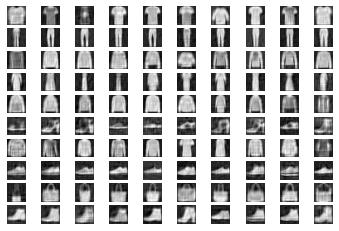

In [18]:
nDims = 40  # P
print(np.shape(x[:,:nDims]), np.shape(evecs[:,:nDims].T))
reconstructedP = np.dot(x[:,:nDims],evecs[:,:nDims].T)
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(reconstructedP[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Reconstructed using P(40) dimensions

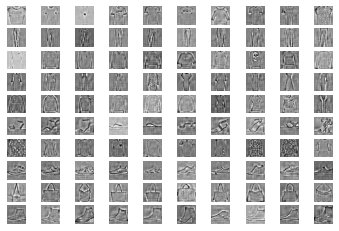

In [19]:
for i in range(10):
    thing = np.squeeze(np.where(classes[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        difference = (reconstructedP[thing[j]]-images[thing[j]]+255)/2
        pl.imshow(difference.reshape((28, 28)), cmap='gray')
        pl.axis('off')
# Difference from being reconstructed using P(40) dimensions

In [20]:
df = pd.DataFrame(data = reconstructedP)
k=10
kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, tol = 0.0001, random_state = 1, algorithm = 'full')
kmeansFitP = kmeans.fit(df)
print(kmeansFitP)

KMeans(algorithm='full', n_clusters=10, random_state=1)


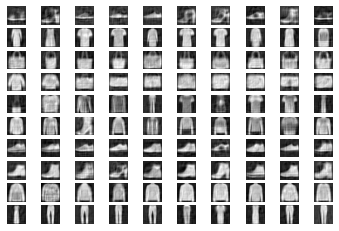

In [21]:
for i in range(10):
    thing = np.squeeze(np.where(kmeans.labels_[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(reconstructedP[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')

Class 0 :  T-shirt/top
Class 1 :  Trouser
Class 2 :  Pullover
Class 3 :  Dress
Class 4 :  Coat
Class 5 :  Sandal
Class 6 :  Shirt
Class 7 :  Sneaker
Class 8 :  Bag
Class 9 :  Ankle boot
------
Actual class of the corresponding images:
[[5. 5. 5. 5. 7. 5. 5. 5. 5. 5.]
 [3. 3. 0. 0. 4. 6. 0. 3. 6. 0.]
 [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
 [0. 2. 8. 8. 8. 8. 8. 8. 8. 8.]
 [8. 0. 6. 2. 1. 0. 0. 0. 0. 3.]
 [6. 6. 9. 4. 4. 4. 4. 2. 6. 6.]
 [7. 7. 7. 7. 9. 9. 5. 7. 7. 7.]
 [9. 9. 9. 5. 9. 9. 9. 9. 9. 9.]
 [4. 6. 4. 4. 4. 4. 2. 6. 4. 2.]
 [3. 1. 1. 1. 1. 1. 3. 3. 1. 1.]]


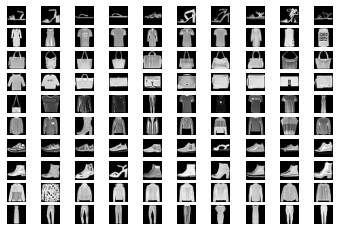

In [22]:
actuals = np.zeros((10, 10))
for i in range(10):
    print("Class", i, ": ", classLabels[i])
    thing = np.squeeze(np.where(kmeans.labels_[:] == i))
    for j in range(cols):
        pl.subplot(10, cols, cols*i+j+1)
        pl.imshow(images[thing[j]].reshape((28, 28)), cmap='gray')
        pl.axis('off')
        actuals[i, j] = classes[thing[j]]
print("------")
print("Actual class of the corresponding images:")
print(actuals)   # The actual class of the corresponding image

The $k$-means clustering has varying success. There appear to be multiple instances of clustering of Bags (Class 8) and Ankle boots (Class 9), with one cluster being exclusively items of that class, and other clusters having other items of clothing included.

For example, Clusters 9 and 7 have exclusively item of class 8 and 9 respectively, but Clusters 3 and 0 have some items that aren't in either class 8 or 9 respectively.

Other clusters like Clusters 1, 2, and 6 have multiple items of different classes, and so there is some discrepancies between the given classes and the clustered data.

$k$-means is an unsupervised method, which makes it hard to compute accuracy metrics. We would have to work out what each class was meant to be and label them appropriately. Instead, we will have a forward look at a method you will see later in the course, the Support Vector Machine. In sklearn this is available using `from sklearn.svm import SVC`. 

We will need to preprocess the data using the `StandardScaler` that we've seen before. 

**Task 6:** Split the data into 2000 training and 1000 testing images. Then train the SVM using:
- `clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))`
- `clf.fit(training,labels)` 
- `clf.predict(testing)`

Print out the accuracy and the confusion matrix for the classifier. Comment on the results (3 marks)

In [23]:
images_train, images_test, classes_train, classes_test = train_test_split(images, classes, test_size=1000/3000)

In [24]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
t = time.time()
clf.fit(images_train, classes_train)
classes_pred = clf.predict(images_test)
print(time.time()-t)

3.771768093109131


In [25]:
c_matrix = confusion_matrix(classes_test, classes_pred)
print(c_matrix)
correct = 0.0
for i in range(10):
    correct += c_matrix[i, i]
print("Proportion of correct guesses overall", ": ", correct/np.sum(c_matrix))
for i in range(10):
    print(" - for Class", i, "(", classLabels[i], ") : ", c_matrix[i, i]/np.sum(c_matrix[i, :]))

[[82  0  0  9  0  1  5  0  3  0]
 [ 1 93  0  6  0  0  0  0  0  0]
 [ 1  0 75  0 16  1 10  0  0  0]
 [ 3  0  1 95  1  0  6  0  2  0]
 [ 0  1  6 11 76  0 10  0  0  0]
 [ 0  0  0  0  0 83  0 16  1  0]
 [16  0 11 11  6  1 41  0  8  0]
 [ 0  0  0  0  0  8  0 83  0  2]
 [ 0  0  0  0  0  1  1  1 91  0]
 [ 1  0  0  0  0  4  0  5  5 89]]
Proportion of correct guesses overall :  0.808
 - for Class 0 ( T-shirt/top ) :  0.82
 - for Class 1 ( Trouser ) :  0.93
 - for Class 2 ( Pullover ) :  0.7281553398058253
 - for Class 3 ( Dress ) :  0.8796296296296297
 - for Class 4 ( Coat ) :  0.7307692307692307
 - for Class 5 ( Sandal ) :  0.83
 - for Class 6 ( Shirt ) :  0.43617021276595747
 - for Class 7 ( Sneaker ) :  0.8924731182795699
 - for Class 8 ( Bag ) :  0.9680851063829787
 - for Class 9 ( Ankle boot ) :  0.8557692307692307


Each time I've run the program, the SVC's predictions were correct least 80% of the time.

The predictions for Class 8 (Bags) and for Class 1 (Trousers) seem to be the most accurate, with each being over 90% accurate each time. This may be attributed to the lack of similarity with other classes.
However, the predictions for Class 6 (Shirts) score significantly below 60%. This may be because of the shirts' similarity to other items of clothing, namely T-shirts/tops (Class 0) and Pullovers (Class 2).

This method of predicting classes of clothing is accurate for items that have few similarities with other classes, but struggles with classes that have a lot in common with other classes of clothing.